In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix 
from scipy import interp, stats
from imblearn.over_sampling import ADASYN 
import seaborn as sns

### TO LOAD DATA

In [2]:
# TO IMPORT CVS FILES (REGARDING FREQUENCY OF FEATURES)
all_features_list_df_lin=pd.read_csv("training_linear_all_features_list_result.csv",index_col=False)
all_features_count_df_lin=all_features_list_df_lin.stack().value_counts() # it returns a df with the frequency for each features

In [3]:
# TO IMPORT CVS FILE AND CREATE A PD DATAFRAME WITH ONLY THE FIRST n SELECTED FEATURES - TRAINING DATASET

first_n_features_to_select_lin=5 # choose the value

# load the original dataset
training_dataframe_df_lin=pd.read_csv("training - linear after WEKA CfsSubsetEval.csv",index_col='exam')
size_mapping={"codeletion":0,"noncodeletion":1} # MAPPING for outcome 
training_dataframe_df_lin["outcome"]=training_dataframe_df_lin["outcome"].map(size_mapping)

training_feature_names_lin = [x[2:-2] for x in [*all_features_count_df_lin.index]]
training_selected_features_lin = training_feature_names_lin[:first_n_features_to_select_lin]
training_New_dataframe_lin = training_dataframe_df_lin[training_selected_features_lin]
training_New_dataframe_lin["outcome"] = training_dataframe_df_lin["outcome"] 
training_dataframe_with_selected_features_df_lin = training_New_dataframe_lin

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [4]:
print ("The chosen features are:", [x[1:-1] for x in [*training_selected_features_lin]])

The chosen features are: ['Wavelet_LLH_Stats_median (T1)', 'Wavelet_LHL_Stats_median (T1)', 'Wavelet_LLL_IH_p10 (T1)', 'GLCM_clusShade (T1)', 'Wavelet_LHH_Fractal_lacunarity (T2)']


## Training and testing the model on training dataset (CROSS VALIDATION)

In [5]:
model_lin = RandomForestClassifier(random_state=1, n_estimators=100) # Choose the model
CV = 10 # Choose the number of folds for cross validation
cv = StratifiedKFold(CV)

In [6]:
# To rename dataframe into X_np, Y_np (numpy arrays)
X_np_lin=training_dataframe_with_selected_features_df_lin.drop('outcome',axis=1).values
Y_np_lin=training_dataframe_with_selected_features_df_lin['outcome'].values

In [7]:
# Run classifier with cross-validation

Y_trues_lin = []
Y_predictions_lin = []
Y_probabilities_lin = []
all_accuracies_lin = []
aucs_lin = []
mean_fpr_lin = np.linspace(0, 1, 100)

for train_lin, test_lin in cv.split(X_np_lin, Y_np_lin):
    
    # StandardScaler
    ss = StandardScaler() 
    X_train_CV_SS_np_lin = ss.fit_transform(X_np_lin[train_lin]) 
    X_test_CV_SS_np_lin = ss.transform(X_np_lin[test_lin])
    
    # ADASYN
    sm = ADASYN(random_state=1)    
    X_train_CV_SS_BAL_np_lin, Y_train_CV_balanced_lin = sm.fit_sample(X_train_CV_SS_np_lin, Y_np_lin[train_lin])
    
    X_for_CV_model_training_lin = X_train_CV_SS_BAL_np_lin  
    Y_for_CV_model_training_lin = Y_train_CV_balanced_lin
    
    # fitting the model
    model_lin.fit (X_for_CV_model_training_lin, Y_for_CV_model_training_lin)
    
    # Compute prediction, probabilities and accuracy
    pred_lin_ = model_lin.predict(X_test_CV_SS_np_lin)
    probas_lin_ = model_lin.predict_proba(X_test_CV_SS_np_lin)
    accuracy_lin_ = accuracy_score(Y_np_lin[test_lin], pred_lin_)
    
    # Compute AUC
    fpr_lin, tpr_lin, thresholds_lin = roc_curve(Y_np_lin[test_lin], probas_lin_[:, 1])   
    roc_auc_lin = auc(fpr_lin, tpr_lin)    
    
    # Store data
    aucs_lin.append(roc_auc_lin)
    Y_trues_lin.extend(Y_np_lin[test_lin])
    Y_predictions_lin.extend(pred_lin_)
    Y_probabilities_lin.extend(probas_lin_)
    all_accuracies_lin.append(accuracy_lin_)

In [8]:
# Rename the values for bootstrap code and De-Long test
y_true_lin = np.array(Y_trues_lin)
y_pred_lin = np.array(Y_predictions_lin)
y_prob_lin = np.array(Y_probabilities_lin)[:,1]

In [9]:
# print Confusion Matrix
print ("Confusion matrix for linear features (Cross Validation - training dataset): \n", confusion_matrix(y_true_lin, y_pred_lin))

Confusion matrix for linear features (Cross Validation - training dataset): 
 [[83 19]
 [16 41]]


In [10]:
# Perform bootstrap with y_true, predictions, probabilities from CV model

n_bootstraps = 10000
rng_seed = 1  # control reproducibility

bootstrapped_acc_lin = []
bootstrapped_auc_lin = []
bootstrapped_sens_lin = []
bootstrapped_spec_lin = []

bootstrapped_tpr_lin = []
bootstrapped_fpr_lin = []
bootstrapped_thr_lin = []

bootstrapped_tprs_lin = []

mean_fpr = np.linspace(0, 1, 100)

rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices_0=np.where(y_true_lin == 0)
    indices_1=np.where(y_true_lin == 1)
    
    # 'balanced bootstrapping'
    random_indices_0=rng.choice(indices_0[0],len(indices_0[0]))
    random_indices_1=rng.choice(indices_1[0],len(indices_0[0]))
    random_indices=np.concatenate((random_indices_0,random_indices_1), axis=None)
    
    acc_lin = accuracy_score(y_true_lin[random_indices], y_pred_lin[random_indices])
    auc_lin = roc_auc_score(y_true_lin[random_indices], y_prob_lin[random_indices])
    sens_lin = recall_score(y_true_lin[random_indices], y_pred_lin[random_indices], pos_label=1)
    spec_lin = recall_score(y_true_lin[random_indices], y_pred_lin[random_indices], pos_label=0)
    
    fpr_lin, tpr_lin, threshold_lin = roc_curve(y_true_lin[random_indices], y_prob_lin[random_indices])
    
    interp_tpr_lin = interp(mean_fpr, fpr_lin, tpr_lin)
    interp_tpr_lin[0] = 0.0
    bootstrapped_tprs_lin.append(interp_tpr_lin)
    
    bootstrapped_acc_lin.append(acc_lin)
    bootstrapped_auc_lin.append(auc_lin)
    bootstrapped_sens_lin.append(sens_lin)
    bootstrapped_spec_lin.append(spec_lin)

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

metrics distributions for bootstrapping steps

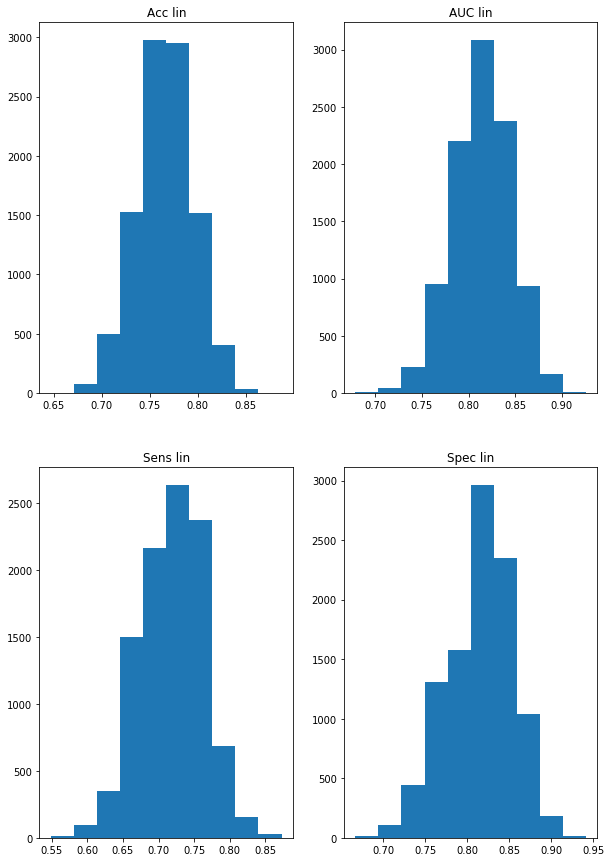

In [11]:
plt.figure(figsize=(10, 15))

plt.subplot(2,2,1)
plt.hist(bootstrapped_acc_lin)
plt.title('Acc lin')

plt.subplot(2,2,2)
plt.hist(bootstrapped_auc_lin)
plt.title('AUC lin')

plt.subplot(2,2,3)
plt.hist(bootstrapped_sens_lin)
plt.title('Sens lin')

plt.subplot(2,2,4)
plt.hist(bootstrapped_spec_lin)
plt.title('Spec lin')

plt.show()

distr normality test (Shapiro-Wilcoxon)

In [12]:
print ('Acc lin: ', stats.shapiro(bootstrapped_acc_lin))
print ('AUC lin: ', stats.shapiro(bootstrapped_auc_lin))
print ('Sens lin: ', stats.shapiro(bootstrapped_sens_lin))
print ('Spec lin: ', stats.shapiro(bootstrapped_spec_lin))

Acc lin:  (0.9971224665641785, 5.136795394426741e-13)
AUC lin:  (0.9978577494621277, 1.172570929242056e-10)
Sens lin:  (0.9949800372123718, 3.449984012525701e-18)
Spec lin:  (0.9924432635307312, 1.3463006917621737e-22)


/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p-values are small -> distr is not normal -> estimation should be represented as median (low_percentile, up_percentile)

In [13]:
print ('Acc lin: {} ({}, {})'.format(np.median(bootstrapped_acc_lin), np.percentile(bootstrapped_acc_lin, 2.5), np.percentile(bootstrapped_acc_lin, 97.5)))
print ('AUC lin: {} ({}, {})'.format(np.median(bootstrapped_auc_lin), np.percentile(bootstrapped_auc_lin, 2.5), np.percentile(bootstrapped_auc_lin, 97.5)))
print ('Sens lin: {} ({}, {})'.format(np.median(bootstrapped_sens_lin), np.percentile(bootstrapped_sens_lin, 2.5), np.percentile(bootstrapped_sens_lin, 97.5)))
print ('Spec lin: {} ({}, {})'.format(np.median(bootstrapped_spec_lin), np.percentile(bootstrapped_spec_lin, 2.5), np.percentile(bootstrapped_spec_lin, 97.5)))

Acc lin: 0.7647058823529411 (0.7058823529411765, 0.8235294117647058)
AUC lin: 0.8151912725874664 (0.7513912918108419, 0.871925461361015)
Sens lin: 0.7156862745098039 (0.6274509803921569, 0.803921568627451)
Spec lin: 0.8137254901960784 (0.7352941176470589, 0.8823529411764706)


## ROC CURVE AND AUC

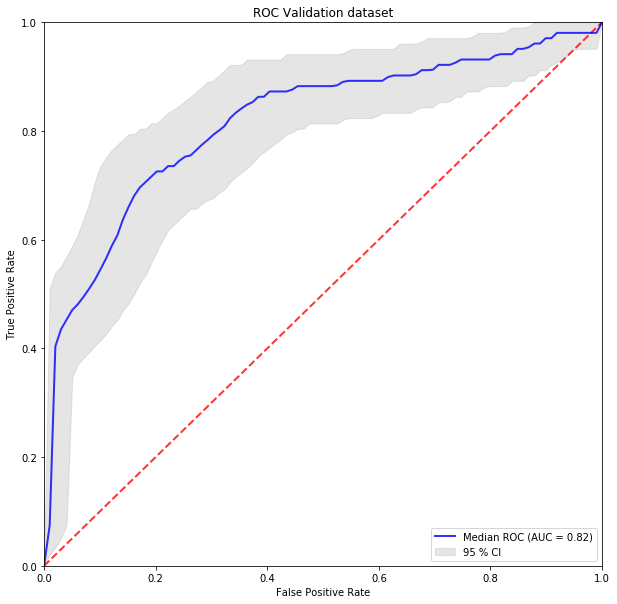

In [14]:
# ROC CURVE

fig, ax = plt.subplots(figsize=(10,10))  

plt.title('ROC Validation dataset')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

mean_tpr_lin = np.median(bootstrapped_tprs_lin, axis=0)  
mean_tpr_lin[-1] = 1.0                
plt.plot(mean_fpr, mean_tpr_lin, color='b', 
        label=r'Median ROC (AUC = %0.2f)' % (np.median(bootstrapped_auc_lin)), 
        lw=2, alpha=.8)

tprs_upper = np.percentile(bootstrapped_tprs_lin, 2.5,  axis = 0)
tprs_lower = np.percentile(bootstrapped_tprs_lin, 97.5, axis = 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='95 % CI')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.legend(loc="lower right")
plt.show()